In [1]:
#import library
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Data-Science/PORT/ELECTRIC_FORECAST/data/"
# data source from https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption
path_data_file  = path+"household_power_consumption.txt"

In [4]:
#read data
df = pd.read_csv(path_data_file, sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
# dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [6]:
# Check for missing values
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [7]:
#check dubplicated
df.duplicated().sum()

0

In [8]:
#check na group
na_groups = df['Sub_metering_3'].notna().cumsum()[df['Sub_metering_3'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)

longest_na_gap = len_consecutive_na.max()
longest_na_gap

7226

In [9]:
# Remove Sub_metering_3 column as the length of consecutive missing values
# is too large to fill with another value

df = df.drop(['Sub_metering_3'], axis=1)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000


In [10]:
df.dtypes

Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
dtype: object

In [11]:
# Transform all values to numeric except for date and time
cols_to_convert = df.columns[2:]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [12]:
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

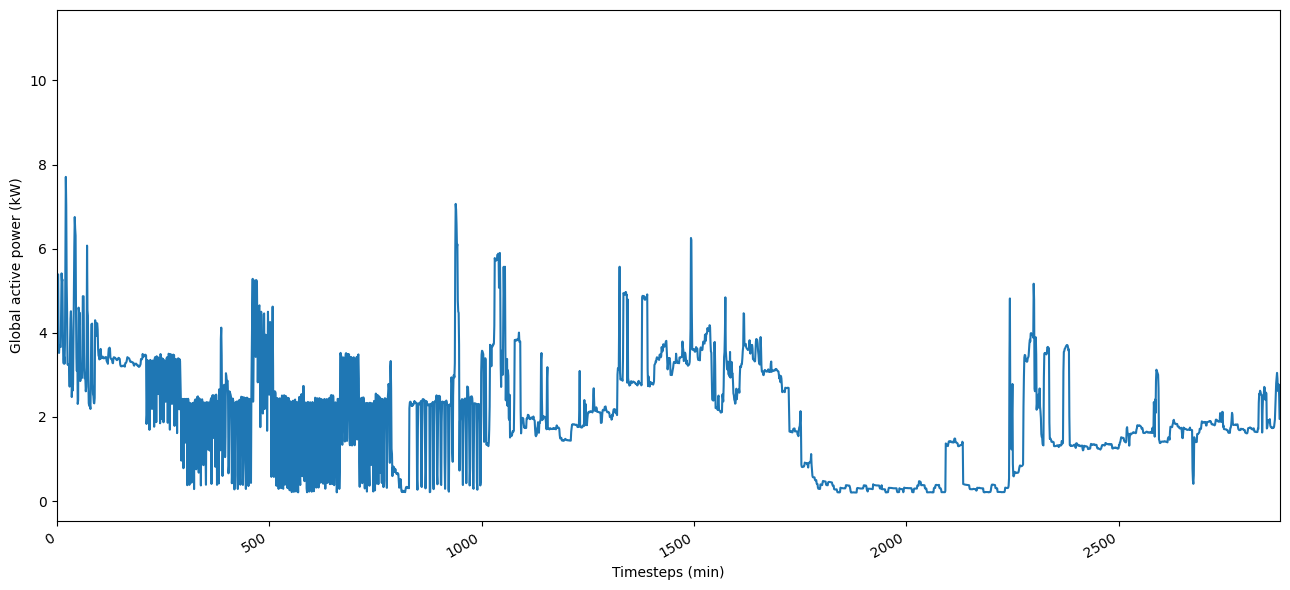

In [13]:
#plot data
fig, ax = plt.subplots(figsize=(13,6))
ax.plot(df['Global_active_power'])
ax.set_xlabel('Timesteps (min)')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 2880)

fig.autofmt_xdate()
plt.tight_layout()

In [14]:
# Create new datetime column to have date formatted correctly
df.loc[:,'datetime'] = pd.to_datetime(df.Date.astype(str) + ' ' + df.Time.astype(str))

# Drop old date and tiem columns
df = df.drop(['Date', 'Time'], axis=1)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,2006-12-16 17:28:00


In [15]:
#create hourly dataframe
hourly_df = df.resample('H', on='datetime').sum()
hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0


In [16]:
# Drop first and last row of data so that we have only full 24h sums
hourly_df = hourly_df.drop(hourly_df.tail(1).index)
hourly_df = hourly_df.drop(hourly_df.head(1).index)
hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


In [17]:
hourly_df = hourly_df.reset_index()
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


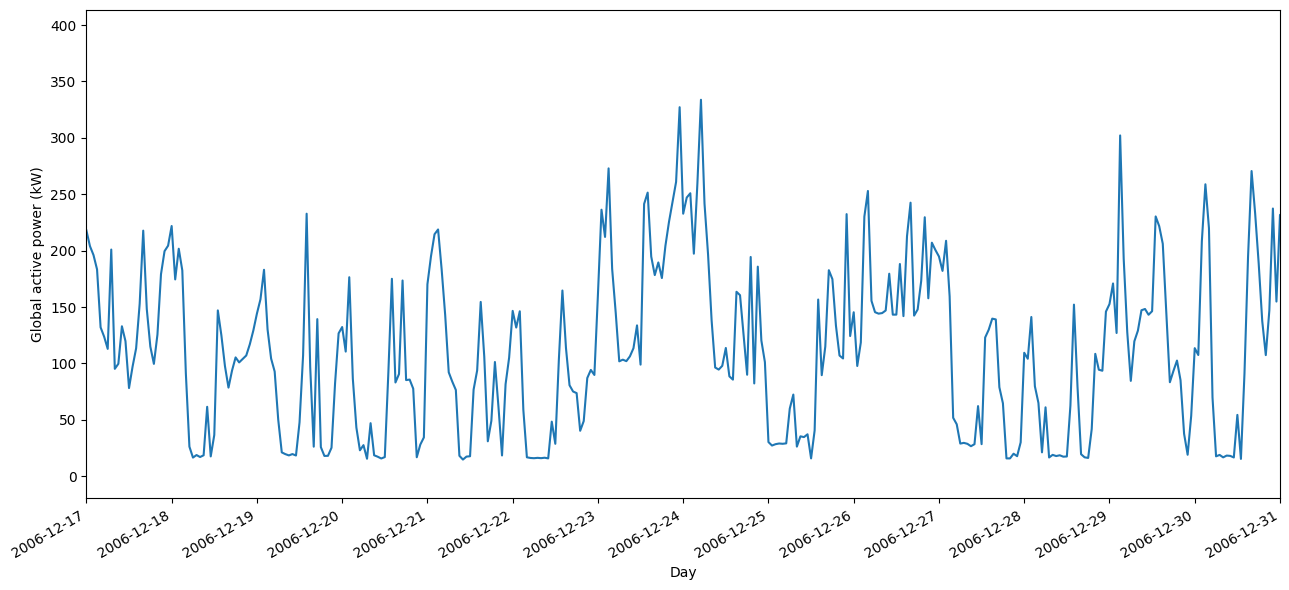

In [18]:
# Plot first 15 full days of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(hourly_df['Global_active_power'])
ax.set_xlabel('Day')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 336)

plt.xticks(np.arange(0, 360, 24), ['2006-12-17', '2006-12-18', '2006-12-19', '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23', '2006-12-24', '2006-12-25', '2006-12-26', '2006-12-27', '2006-12-28', '2006-12-29', '2006-12-30', '2006-12-31'])

fig.autofmt_xdate()
plt.tight_layout()

In [19]:
path_clean_data  = path+"clean_data.csv"
hourly_df.to_csv(path_clean_data, header=True, index=False)

In [20]:
hourly_df = pd.read_csv(path_clean_data)
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


In [21]:
hourly_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34949.0,64.002817,54.112103,0.0,19.974,45.868,93.738,393.632
Global_reactive_power,34949.0,7.253838,4.113238,0.0,4.558,6.324,8.884,46.460
Voltage,34949.0,14121.298311,2155.548246,0.0,14340.300,14454.060,14559.180,15114.120
Global_intensity,34949.0,271.331557,226.626113,0.0,88.400,196.600,391.600,1703.000
Sub_metering_1,34949.0,65.785430,210.107036,0.0,0.000,0.000,0.000,2902.000
Sub_metering_2,34949.0,76.139861,248.978569,0.0,0.000,19.000,39.000,2786.000


In [22]:
hourly_df = hourly_df.drop(['Sub_metering_1'], axis=1)
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,8.0


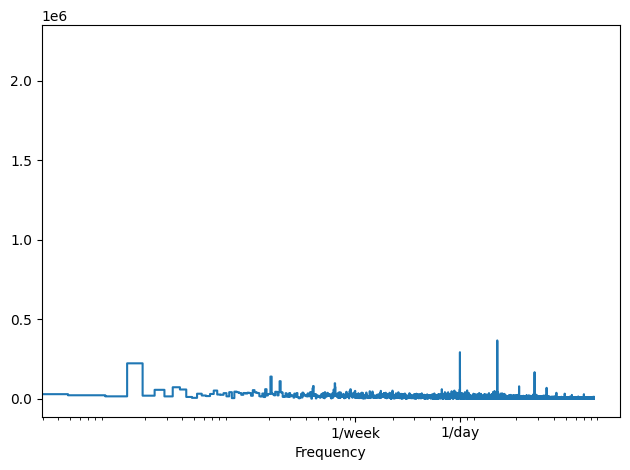

In [23]:
#fourier
fft = tf.signal.rfft(hourly_df['Global_active_power'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(hourly_df['Global_active_power'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
#plt.step(f_per_week,fft)
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [24]:
#create feature  day_sin,cos_sin
timestamp_s = pd.to_datetime(hourly_df.datetime).map(datetime.datetime.timestamp)

#number of second in a day
day = 24 * 60 * 60

hourly_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
hourly_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [25]:
hourly_df = hourly_df.drop(['datetime'], axis=1)
hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,day_sin,day_cos
0,217.932,4.802,14074.81,936.0,403.0,-1.000000,-4.501728e-12
1,204.014,5.114,13993.95,870.2,86.0,-0.965926,2.588190e-01
2,196.114,4.506,14044.29,835.0,0.0,-0.866025,5.000000e-01
3,183.388,4.600,14229.52,782.8,25.0,-0.707107,7.071068e-01
4,132.008,3.370,14325.60,571.4,8.0,-0.500000,8.660254e-01


In [26]:
n = len(hourly_df)

#train 70  val 20  holdout 10
# Split 70:20:10 (train:validation:test)
train_df = hourly_df[0:int(n*0.7)]
val_df = hourly_df[int(n*0.7):int(n*0.9)]
test_df = hourly_df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((24464, 7), (6990, 7), (3495, 7))

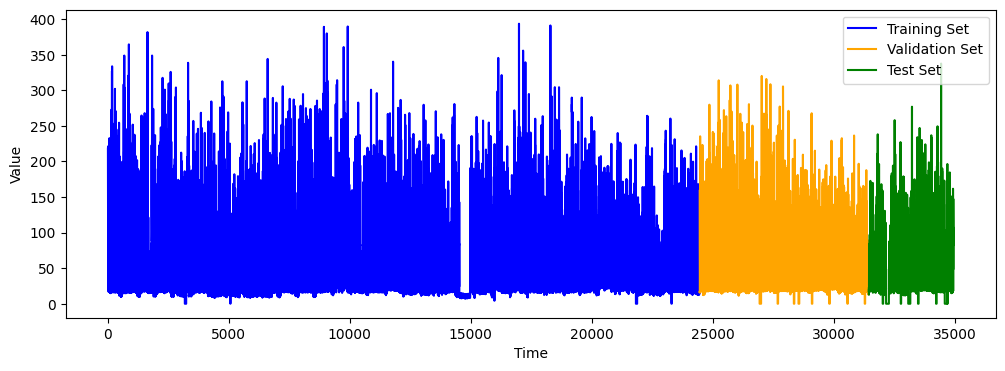

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(train_df['Global_active_power'],label='Training Set', color='blue')
plt.plot(val_df['Global_active_power'],label='Validation Set',color='orange')
plt.plot(test_df['Global_active_power'],label='Test Set',color='green')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [28]:
train_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,day_sin,day_cos
0,217.932,4.802,14074.81,936.0,403.0,-1.000000,-4.501728e-12
1,204.014,5.114,13993.95,870.2,86.0,-0.965926,2.588190e-01
2,196.114,4.506,14044.29,835.0,0.0,-0.866025,5.000000e-01
3,183.388,4.600,14229.52,782.8,25.0,-0.707107,7.071068e-01
4,132.008,3.370,14325.60,571.4,8.0,-0.500000,8.660254e-01


In [29]:
#normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [30]:
#save for train
train_df.to_csv(path+'train.csv', index=False, header=True)
val_df.to_csv(path+'val.csv', index=False, header=True)
test_df.to_csv(path+'test.csv', index=False, header=True)

In [31]:
! pip install tensorflow

In [32]:
#import deep

import tensorflow as tf
from tensorflow import keras
from keras import Model,Sequential
from keras.optimizers import Adam
from keras.layers import  Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import MeanAbsoluteError
from keras.losses import MeanSquaredError

In [33]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

In [35]:
train_df = pd.read_csv(path+'train.csv')
val_df = pd.read_csv(path+'val.csv')
test_df = pd.read_csv(path+'test.csv')


#test_df = test_df[0:1]

print(train_df.shape, val_df.shape, test_df.shape)

(24464, 7) (6990, 7) (3495, 7)


In [36]:
#data window class
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        #print(column_indices)

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        #print(labels)

        return inputs, labels

    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              # print("label_col_index",label_col_index)
              # print("predictions shape",predictions.shape)
              # print("predictions =====>",predictions[n, :, label_col_index])
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [37]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

DataWindow.split_window = split_window

In [38]:
#compile and training model
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [39]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [40]:
column_indices

{'Global_active_power': 0,
 'Global_reactive_power': 1,
 'Voltage': 2,
 'Global_intensity': 3,
 'Sub_metering_2': 4,
 'day_sin': 5,
 'day_cos': 6}

In [41]:
#baseline
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['Global_active_power']

In [42]:
# # Stack three slices, the length of the total window.
# example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
#                            np.array(train_df[100:100+multi_window.total_window_size]),
#                            np.array(train_df[200:200+multi_window.total_window_size])])

# example_inputs, example_labels = multi_window.split_window(example_window)

# print('All shapes are: (batch, time, features)')
# print(f'Window shape: {example_window.shape}')
# print(f'Inputs shape: {example_inputs.shape}')
# print(f'Labels shape: {example_labels.shape}')

In [43]:
# repeat last value
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        #print(self.label_index)
        if self.label_index is None:
            result  =  tf.tile(inputs[:, -1:, :], [1, 24, 1])
        else:
            result  =  tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])
        #print(result ,result.shape)
        return result

In [44]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Global_active_power'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)


217/217 [==============================] - 2s 9ms/step - loss: 0.1788 - mean_absolute_error: 0.3018


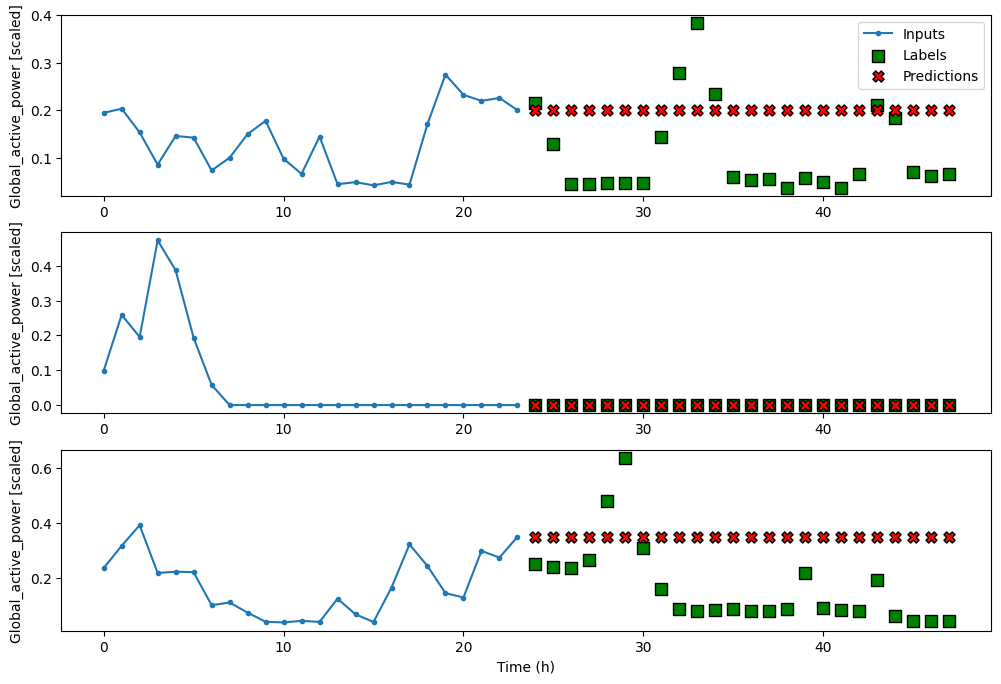

In [45]:
multi_window.plot(baseline_last)

In [46]:
out  = baseline_last.predict(multi_window.test)
batch_size, sequence_length, num_features =  out.shape
print("batch_size " , batch_size)
print("sequence_length ", sequence_length)
print("num_features " , num_features)

108/108 [==============================] - 1s 6ms/step
batch_size  3448
sequence_length  24
num_features  7


In [47]:
# predictions_for_instance = out[0, :, :]
# predictions_for_instance[]

out[0, :, 0]
out[1, :, 0]

array([0.2879644, 0.2879644, 0.2879644, 0.2879644, 0.2879644, 0.2879644,
       0.2879644, 0.2879644, 0.2879644, 0.2879644, 0.2879644, 0.2879644,
       0.2879644, 0.2879644, 0.2879644, 0.2879644, 0.2879644, 0.2879644,
       0.2879644, 0.2879644, 0.2879644, 0.2879644, 0.2879644, 0.2879644],
      dtype=float32)

In [48]:
# def model_forecast(model, series, window_size, batch_size):
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size, shift=24, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size))
#     ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
#     forecast = model.predict(ds)
#     return forecast

# series_test  = test_df.iloc[0:100]
# output  =  model_forecast(baseline_last,series_test,24,32)
# output.shape

In [49]:
def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
    forecast = model.predict(ds)
    return forecast


test_df_predict = test_df.iloc[0:50]
print(test_df_predict.shape)





# def make_preds(model, input_data):
#   """
#   Uses model to make predictions on input_data.

#   Parameters
#   ----------
#   model: trained model
#   input_data: windowed input data (same kind of data model was trained on)

#   Returns model predictions on input_data.
#   """
#   forecast = model.predict(input_data)
#   return tf.squeeze(forecast) # return 1D array of predictions

(50, 7)


In [50]:
# testday = read_csv('https://raw.githubusercontent.com/bbartling/Data/master/test_day.csv', index_col=[0], parse_dates=True)
# testday_copy = testday.copy()

# testday_scaled = scaler.fit_transform(testday.values)
# testday_scaled = np.swapaxes(testday_scaled, 0, 1)

# testday_scaled = testday_scaled[None, ...]
# testday_predict = model.predict(testday_scaled)
# testday_predict = scaler.inverse_transform(testday_predict)

# print("test prediction is: ",testday_predict)


# for i in range(96):

#     last_index_stamp = testday.last_valid_index()
#     print("last_index_stamp: ",last_index_stamp, " i: ",i)

#     new_timestamp = last_index_stamp + timedelta(minutes=15)
#     print("new_timestamp: ",new_timestamp, " i: ",i)

#     testday_scaled = scaler.fit_transform(testday.values)
#     testday_scaled = np.swapaxes(testday_scaled, 0, 1)

#     testday_scaled = testday_scaled[None, ...]
#     testday_predict = model.predict(testday_scaled)
#     testday_predict = scaler.inverse_transform(testday_predict)

#     print("prediction is: ",testday_predict[0][0])

#     # add new row of timestamp and prediction to end of the df
#     testday.loc[new_timestamp,:] = testday_predict[0][0]

#     # remove first df row
#     testday = testday.iloc[1:]

#     print("*******************************************")


In [78]:
class RepeatBaseline(Model):

    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    # def call(self, inputs):
    #     return inputs[:, :, self.label_index:]

    def call(self, inputs):
      if self.label_index is None:
        return inputs
      result = inputs[:, :, self.label_index]
      return result[:, :, tf.newaxis]

In [79]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Global_active_power'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 2s 6ms/step - loss: 0.0218 - mean_absolute_error: 0.1045


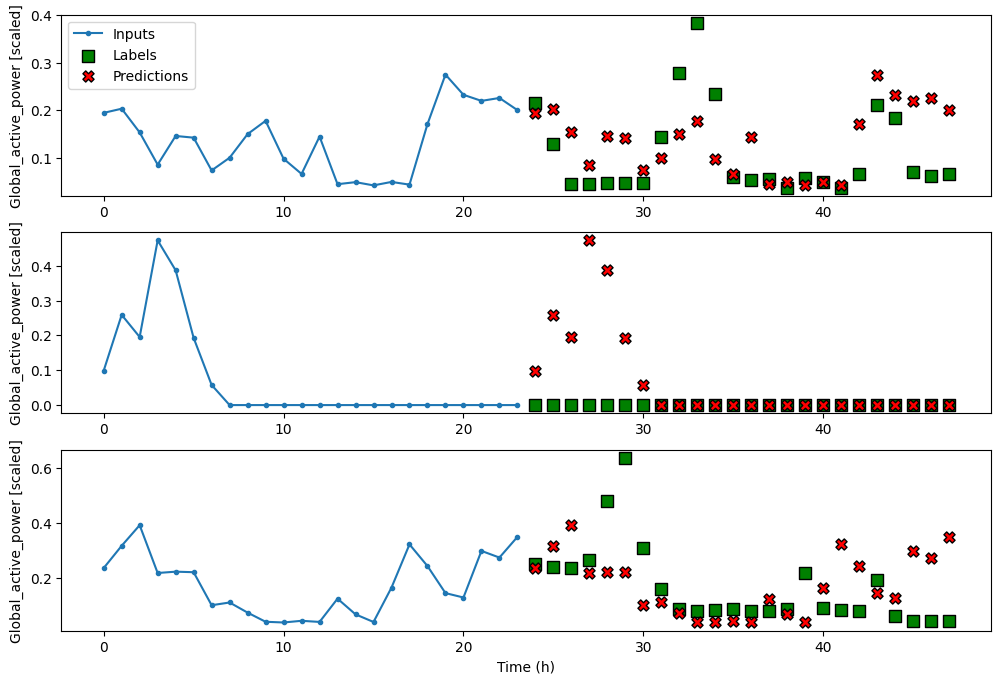

In [80]:
multi_window.plot(baseline_repeat)

In [54]:
label_index = column_indices['Global_active_power']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 8s 10ms/step - loss: 0.0180 - mean_absolute_error: 0.1036 - val_loss: 0.0143 - val_mean_absolute_error: 0.0924
Epoch 2/50
764/764 [==============================] - 8s 11ms/step - loss: 0.0162 - mean_absolute_error: 0.0976 - val_loss: 0.0141 - val_mean_absolute_error: 0.0912
Epoch 3/50
764/764 [==============================] - 10s 13ms/step - loss: 0.0161 - mean_absolute_error: 0.0973 - val_loss: 0.0141 - val_mean_absolute_error: 0.0908
Epoch 4/50
764/764 [==============================] - 7s 10ms/step - loss: 0.0161 - mean_absolute_error: 0.0973 - val_loss: 0.0141 - val_mean_absolute_error: 0.0909
Epoch 5/50
764/764 [==============================] - 13s 17ms/step - loss: 0.0161 - mean_absolute_error: 0.0973 - val_loss: 0.0140 - val_mean_absolute_error: 0.0912
Epoch 6/50
764/764 [==============================] - 4s 6ms/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0918
Epoch 7/5

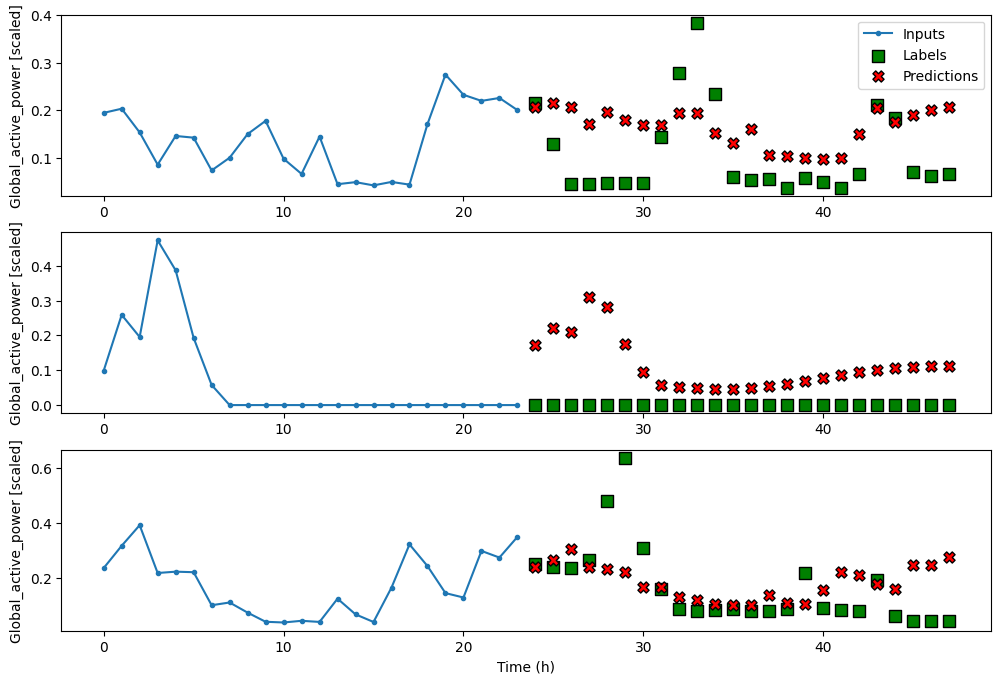

In [55]:
multi_window.plot(linear)

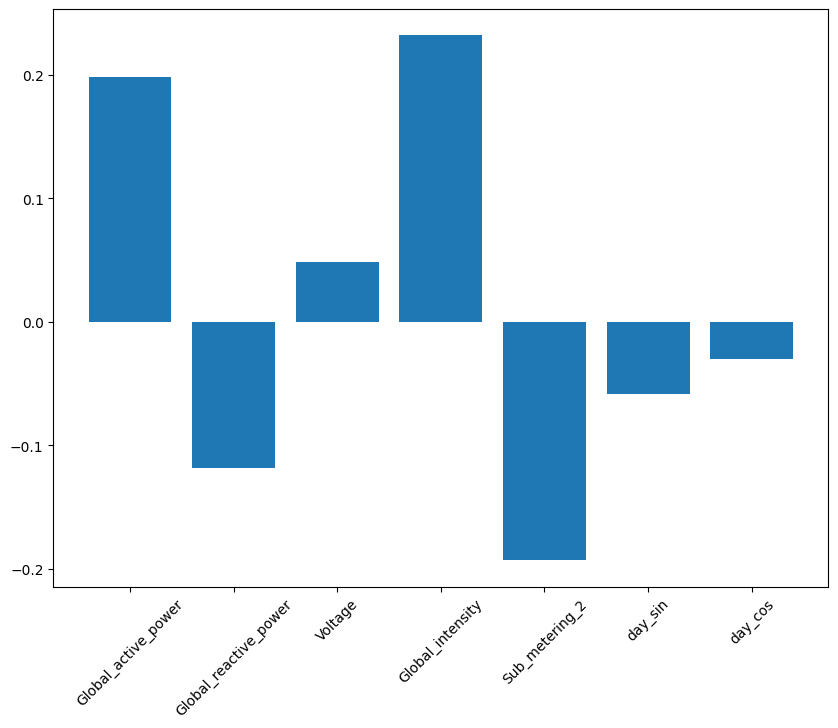

In [56]:
plt.bar( x= range(len(train_df.columns)),
          height=linear.layers[0].kernel[:,0].numpy()
        )
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=45)

In [57]:
#dense
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 9s 9ms/step - loss: 0.0154 - mean_absolute_error: 0.0920 - val_loss: 0.0127 - val_mean_absolute_error: 0.0836
Epoch 2/50
764/764 [==============================] - 6s 8ms/step - loss: 0.0145 - mean_absolute_error: 0.0888 - val_loss: 0.0128 - val_mean_absolute_error: 0.0844
Epoch 3/50
764/764 [==============================] - 7s 9ms/step - loss: 0.0145 - mean_absolute_error: 0.0885 - val_loss: 0.0128 - val_mean_absolute_error: 0.0842
Epoch 4/50
764/764 [==============================] - 5s 7ms/step - loss: 0.0144 - mean_absolute_error: 0.0884 - val_loss: 0.0127 - val_mean_absolute_error: 0.0835
Epoch 5/50
764/764 [==============================] - 5s 7ms/step - loss: 0.0144 - mean_absolute_error: 0.0881 - val_loss: 0.0127 - val_mean_absolute_error: 0.0837
Epoch 6/50
764/764 [==============================] - 8s 10ms/step - loss: 0.0143 - mean_absolute_error: 0.0879 - val_loss: 0.0126 - val_mean_absolute_error: 0.0828
Epoch 7/50
764/

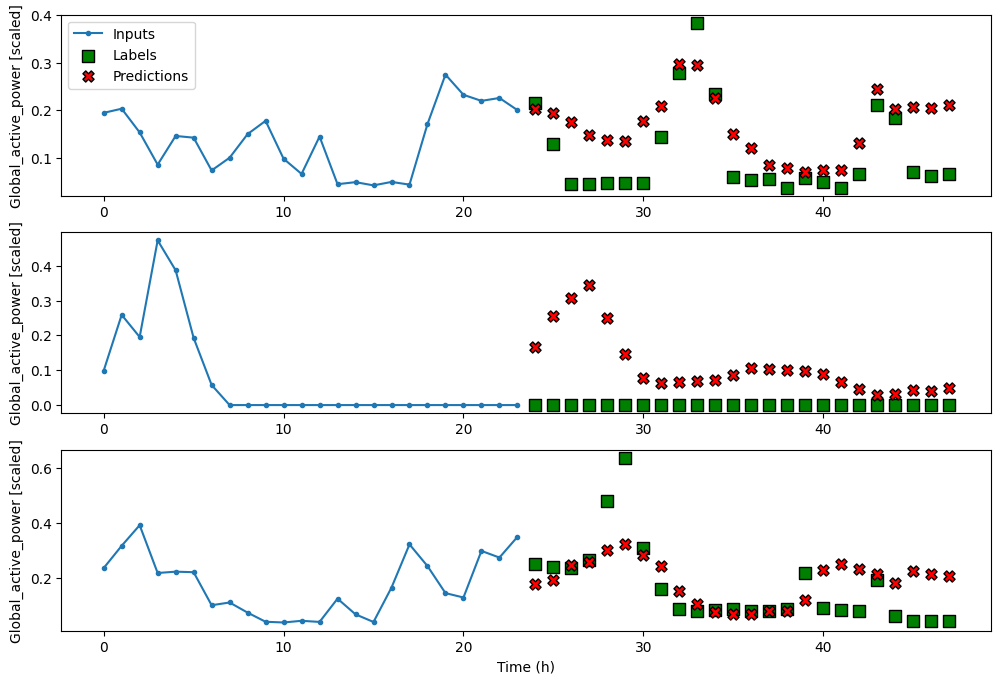

In [58]:
multi_window.plot(dense)

In [59]:
#LSTM
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 19s 18ms/step - loss: 0.0164 - mean_absolute_error: 0.0966 - val_loss: 0.0128 - val_mean_absolute_error: 0.0844
Epoch 2/50
764/764 [==============================] - 15s 20ms/step - loss: 0.0145 - mean_absolute_error: 0.0893 - val_loss: 0.0126 - val_mean_absolute_error: 0.0826
Epoch 3/50
764/764 [==============================] - 14s 18ms/step - loss: 0.0143 - mean_absolute_error: 0.0884 - val_loss: 0.0126 - val_mean_absolute_error: 0.0834
Epoch 4/50
764/764 [==============================] - 15s 20ms/step - loss: 0.0142 - mean_absolute_error: 0.0879 - val_loss: 0.0125 - val_mean_absolute_error: 0.0829
Epoch 5/50
764/764 [==============================] - 14s 18ms/step - loss: 0.0142 - mean_absolute_error: 0.0877 - val_loss: 0.0125 - val_mean_absolute_error: 0.0820
Epoch 6/50
764/764 [==============================] - 15s 20ms/step - loss: 0.0142 - mean_absolute_error: 0.0875 - val_loss: 0.0126 - val_mean_absolute_error: 0.0825
Epoc

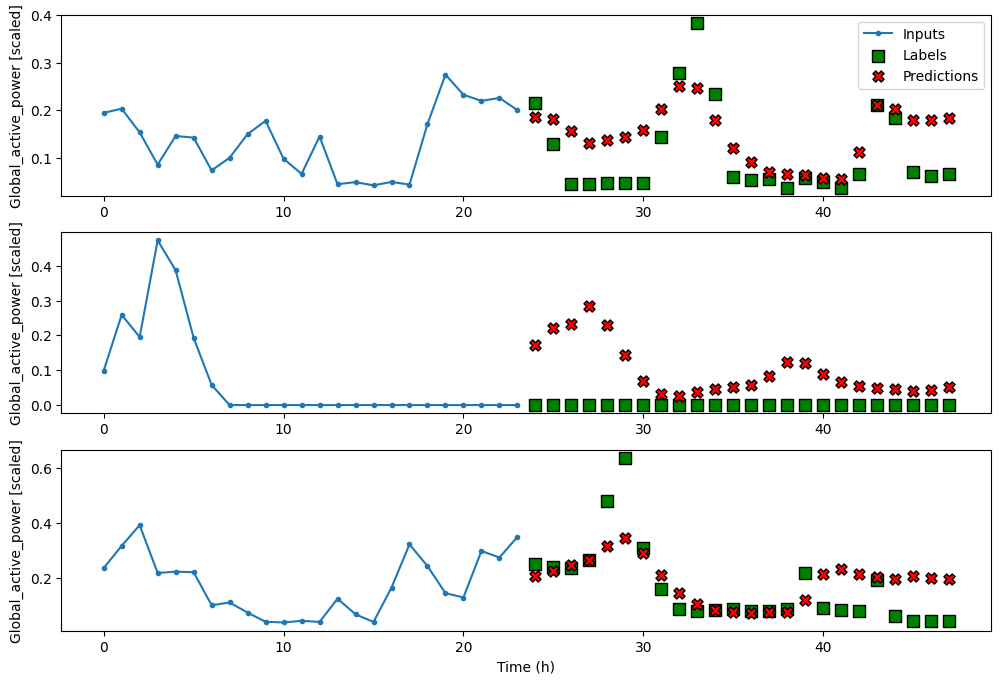

In [60]:
multi_window.plot(lstm_model)

In [61]:
#auto regressive LSTM
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [62]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 27s 27ms/step - loss: 0.0176 - mean_absolute_error: 0.1023 - val_loss: 0.0125 - val_mean_absolute_error: 0.0835
Epoch 2/50
764/764 [==============================] - 19s 24ms/step - loss: 0.0139 - mean_absolute_error: 0.0871 - val_loss: 0.0122 - val_mean_absolute_error: 0.0805
Epoch 3/50
764/764 [==============================] - 20s 26ms/step - loss: 0.0137 - mean_absolute_error: 0.0859 - val_loss: 0.0119 - val_mean_absolute_error: 0.0801
Epoch 4/50
764/764 [==============================] - 20s 26ms/step - loss: 0.0136 - mean_absolute_error: 0.0854 - val_loss: 0.0122 - val_mean_absolute_error: 0.0798
Epoch 5/50
764/764 [==============================] - 19s 24ms/step - loss: 0.0135 - mean_absolute_error: 0.0850 - val_loss: 0.0125 - val_mean_absolute_error: 0.0800
Epoch 6/50
217/217 [==============================] - 3s 13ms/step - loss: 0.0124 - mean_absolute_error: 0.0800


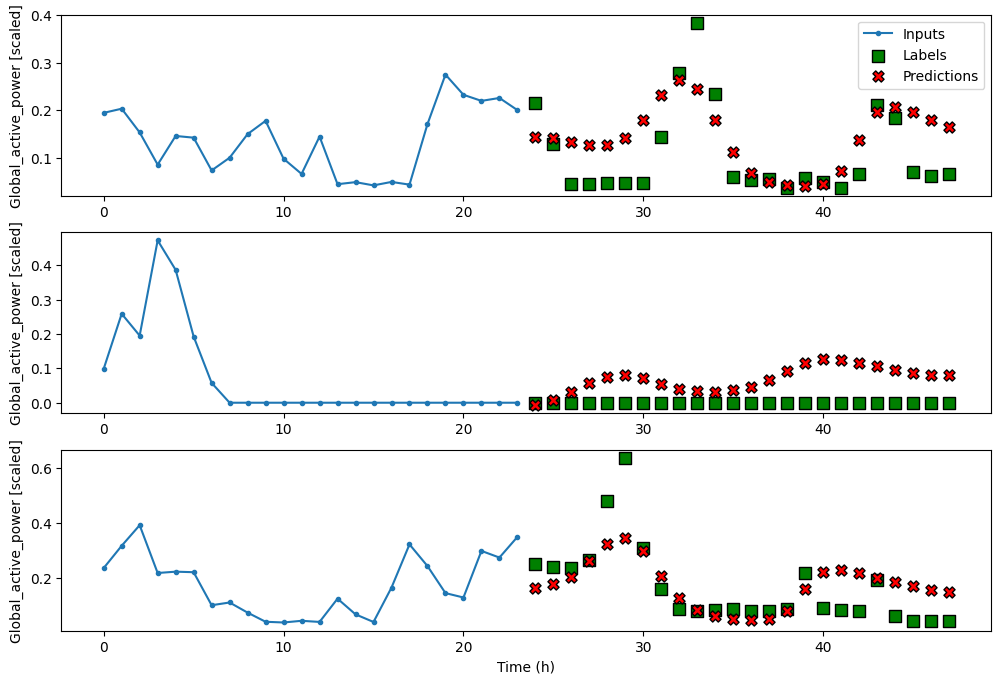

In [63]:
multi_window.plot(AR_LSTM)

In [64]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Global_active_power'])

In [65]:
# cnn_model = Sequential([
#     Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
#     Dense(units=32, activation='relu'),
#     Dense(1, kernel_initializer=tf.initializers.zeros),
# ])

# history = compile_and_fit(cnn_model, cnn_multi_window)

# val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
# performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

In [66]:
# cnn_multi_window.plot(cnn_model)


In [67]:
# cnn_lstm_model = Sequential([
#     Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
#     LSTM(32, return_sequences=True),
#     Dense(1, kernel_initializer=tf.initializers.zeros),
# ])

# history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

# val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
# performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

In [68]:
# cnn_multi_window.plot(cnn_lstm_model)

In [69]:
# keras.utils.plot_model(cnn_lstm_model, show_shapes=False)

In [71]:
# performance.pop('CNN')
# performance.pop('CNN + LSTM')


In [72]:
# val_performance.pop('CNN')
# val_performance.pop('CNN + LSTM')

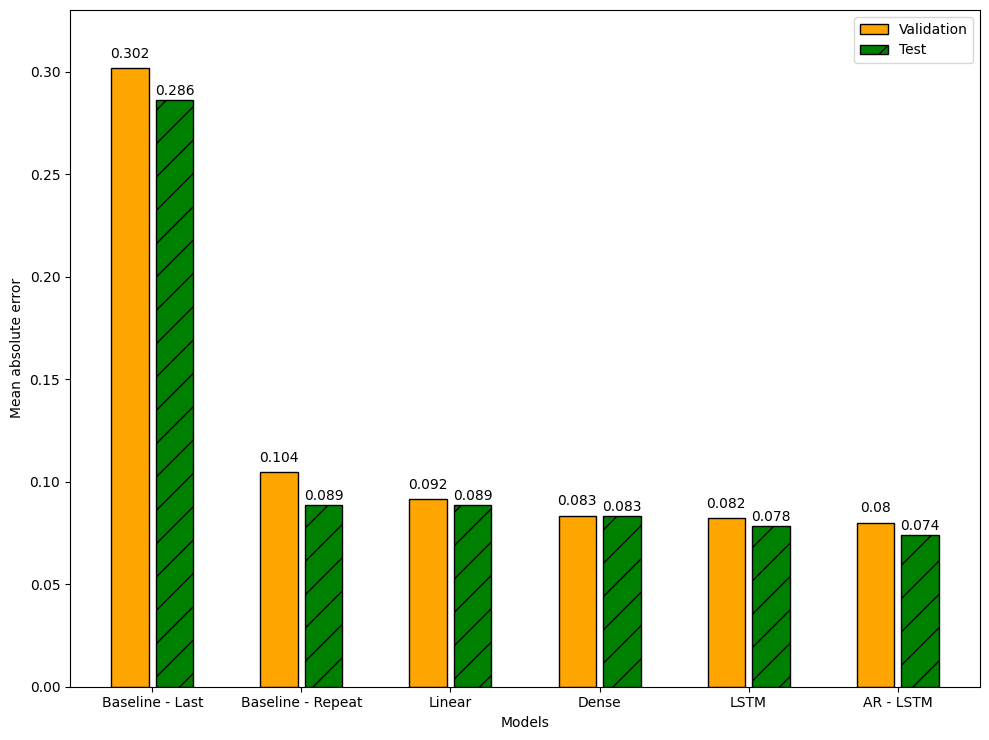

In [77]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='orange', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='green', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

In [81]:
performance

{'Baseline - Last': [0.17630711197853088, 0.2862737774848938],
 'Baseline - Repeat': [0.017816713079810143, 0.08868032693862915],
 'Linear': [0.01241320837289095, 0.08876543492078781],
 'Dense': [0.011800677515566349, 0.0830659344792366],
 'LSTM': [0.011377857066690922, 0.07838928699493408],
 'AR - LSTM': [0.010405001230537891, 0.0740082785487175]}

In [ ]:
# keras.utils.plot_model(lstm_model, show_shapes=True)

In [82]:
# close_data = close_data.reshape((-1))

# def predict(num_prediction, model):
#     prediction_list = close_data[-look_back:]

#     for _ in range(num_prediction):
#         x = prediction_list[-look_back:]
#         x = x.reshape((1, look_back, 1))
#         out = model.predict(x)[0][0]
#         prediction_list = np.append(prediction_list, out)
#     prediction_list = prediction_list[look_back-1:]

#     return prediction_list

# def predict_dates(num_prediction):
#     last_date = df['Date'].values[-1]
#     prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
#     return prediction_dates

# num_prediction = 30
# forecast = predict(num_prediction, model)
# forecast_dates = predict_dates(num_prediction)